In [1]:
# Following blog post from (http://krasserm.github.io/2018/03/19/gaussian-processes/)
# Covariance function as a prior
# Models the joint variability of the GP random variables.
# By choosing a specific kernel function, it is possible to set prior information
# on the distribution.

# Exponential quadratic covariance function
# k(x_a, x_b) = exp(-(1/2*variance^2)*abs(x_a-x_b)^2)
using Distances
using Statistics
using StatsBase
using Distributions
using LinearAlgebra
using Plots
using GaussianProcesses
using GaussianDistributions
using LaTeXStrings

In [2]:
function calcSigma(X1, X2, l=1)
    Sigma = reshape(zeros(length(X1) * length(X2)), :, length(X1))'
    for i in 1:length(X1) # rows
        for j in 1:length(X2) # columns
            Sigma[i,j] = exp(-0.5*(abs(X1[i]-X2[j])/l)^2)
        end
    end
    # Julia's Distributions package uses Cholesky decomposition, we need to add
    # a tiny constant to the diagonal so the determinant does not equal 0
    #small_constant = Diagonal(Array(ones(length(X1)))) * 0.00025
    return Sigma
end

calcSigma (generic function with 2 methods)

In [56]:
# x_star is the "testing" data, where the function is defined
x_star = collect(range(-5, stop=5, length=50))

# calculate covariance matrix of this "testing" data
sigma = calcSigma(x_star, x_star)

# Generate number of functions from the process
num_samples = 3

values = zeros(length(x_star) * num_samples)
values = reshape(values, :, num_samples)

# Each column represents a sample from a multivariate normal, with zero mean and
# covariance sigma
#sigma_sym = Symmetric(sigma)
#sigma_sym = Matrix(sigma_sym)
# create a diagonal matrix of small constant so our determinant is not 0 (Cholesky decomposition)
small_constant = Diagonal(Array(ones(50))) * 0.000025
#test = Matrix(Hermitian(sigma+small_constant))
norm_sample = MvNormal(sigma+small_constant)

values = rand(norm_sample, 3);

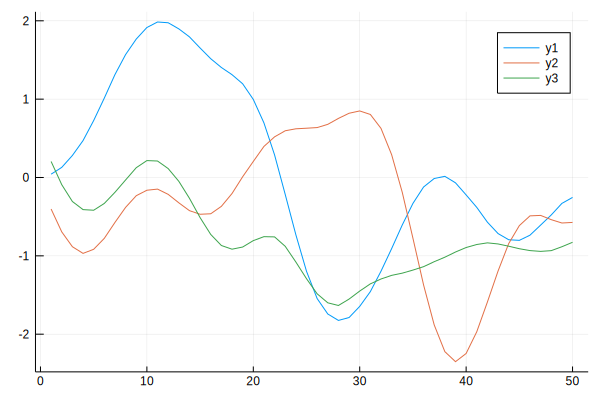

In [57]:
plot(values)

In [58]:
# Now let's assume that we have some known data points;
f = [-4 -3 -1 0 2; -2 0 1 2 -1]

# Calculate the covariance matrices 
# k.xx
# k.xs in the blog is equivalent to x_star / X
# k.x is euivalent to Y (the training data)
k_xx = calcSigma(f[1,:] ,f[1,:])

5×5 Adjoint{Float64,Array{Float64,2}}:
 1.0          0.606531    0.011109  0.000335463  1.523e-8  
 0.606531     1.0         0.135335  0.011109     3.72665e-6
 0.011109     0.135335    1.0       0.606531     0.011109  
 0.000335463  0.011109    0.606531  1.0          0.135335  
 1.523e-8     3.72665e-6  0.011109  0.135335     1.0       

In [59]:
k_xx = k_xx + Diagonal(Array(ones(size(k_xx)[1]))) * 0.000025

5×5 Array{Float64,2}:
 1.00002      0.606531    0.011109  0.000335463  1.523e-8  
 0.606531     1.00002     0.135335  0.011109     3.72665e-6
 0.011109     0.135335    1.00002   0.606531     0.011109  
 0.000335463  0.011109    0.606531  1.00002      0.135335  
 1.523e-8     3.72665e-6  0.011109  0.135335     1.00002   

In [60]:
k_xxs = calcSigma(f[1,:], x_star) ;

In [61]:
k_xsxs = calcSigma(x_star, x_star) ;

In [62]:
k_xsxs = k_xsxs + Diagonal(Array(ones(size(k_xsxs)[1]))) * 0.000025 ;

In [63]:
k_xsx= calcSigma(x_star, f[1,:]) ;

In [64]:
# These matrix calculations correspond to equation 2.19 in the GP book
f_star_bar = k_xsx * inv(k_xx) * f[2,:] ;# the mean function  
cov_f_star = k_xsxs - k_xsx * inv(k_xx) * k_xxs  ;# the covariance function

In [65]:
cov_f_star_hermitian = Matrix(Hermitian(cov_f_star)) ;

In [66]:
# New MVNorm
norm_sample = MvNormal(f_star_bar, cov_f_star_hermitian) 

FullNormal(
dim: 50
μ: [-1.68377, -1.94741, -2.13787, -2.21961, -2.16769, -1.97445, -1.65324, -1.23766, -0.776111, -0.322875  …  -0.669838, -0.521998, -0.389026, -0.277551, -0.189693, -0.12425, -0.0780194, -0.0469739, -0.0271214, -0.0150178]
Σ: [0.544139 0.445787 … -8.14748e-5 -4.51652e-5; 0.445787 0.373665 … -8.34715e-5 -4.62721e-5; … ; -8.14748e-5 -8.34715e-5 … 0.999611 0.979162; -4.51652e-5 -4.62721e-5 … 0.979162 0.999898]
)


In [67]:
# Plot more samples
num_samples = 50 ;
values = rand(norm_sample, num_samples) ;

In [68]:
values

50×50 Array{Float64,2}:
 -0.768586   -1.94957    -2.13797    …  -1.50596    -0.727513   -1.99199  
 -1.23124    -2.14891    -2.31275       -1.83271    -1.03583    -2.16904  
 -1.65427    -2.26522    -2.37582       -2.09265    -1.36003    -2.30956  
 -1.94808    -2.28187    -2.32702       -2.22646    -1.64261    -2.34769  
 -2.06612    -2.174      -2.20099       -2.17824    -1.87809    -2.23559  
 -1.98815    -1.96398    -1.9715     …  -1.96938    -1.99956    -1.95997  
 -1.73732    -1.66569    -1.68023       -1.62158    -1.95805    -1.55081  
 -1.36387    -1.27081    -1.28166       -1.18463    -1.70804    -1.06284  
 -0.903051   -0.827822   -0.823915      -0.731371   -1.22583    -0.600048 
 -0.402312   -0.363649   -0.345107      -0.305402   -0.581547   -0.217953 
  0.0791165   0.0848863   0.0866248  …   0.0517851   0.148635    0.0301487
  0.524656    0.466212    0.405988       0.328613    0.830857    0.130108 
  0.836465    0.742422    0.553299       0.50418     1.36557     0.111151 
 

In [69]:
marginal_std = std(values, dims=2) ;

In [70]:
marginal_mean = mean(values, dims=2) ;

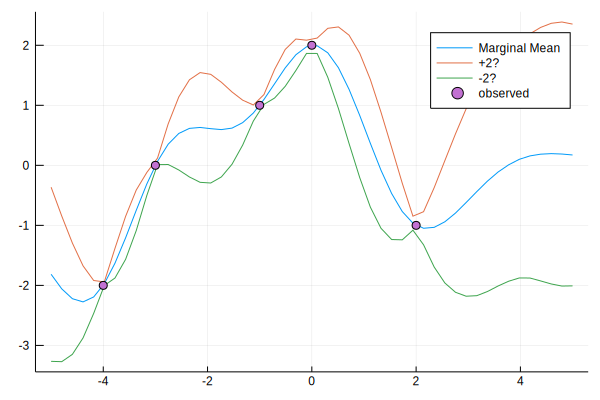

In [74]:
plot(x_star, marginal_mean, lab="Marginal Mean");
plot!(x_star, marginal_mean + (2*marginal_std), lab="+2 S.D");
plot!(x_star, marginal_mean - (2*marginal_std), lab="-2 S.D")
scatter!(f[1,:], f[2,:], lab="observed")

---

Now assume that each of the observed data points have normally distributed noise

In [97]:
σ_noise = 0.2 ;

In [99]:
k_xx + σ_noise^2 * Diagonal(ones(size(k_xx)[2]))

5×5 Array{Float64,2}:
 1.04002      0.606531    0.011109  0.000335463  1.523e-8  
 0.606531     1.04002     0.135335  0.011109     3.72665e-6
 0.011109     0.135335    1.04002   0.606531     0.011109  
 0.000335463  0.011109    0.606531  1.04002      0.135335  
 1.523e-8     3.72665e-6  0.011109  0.135335     1.04002   

In [100]:
# Recalculate the mean and covariance function
f_star_bar = k_xsx * inv(k_xx + σ_noise^2 * Diagonal(ones(size(k_xx)[2]))) * f[2,:] ;# the mean function  
cov_f_star = k_xsxs - k_xsx * inv(k_xx + σ_noise^2 * Diagonal(ones(size(k_xx)[2]))) * k_xxs  ;# the covariance function

In [101]:
cov_f_star_hermitian = Matrix(Hermitian(cov_f_star)) ;

In [102]:
# New MVNorm
norm_sample = MvNormal(f_star_bar, cov_f_star_hermitian) 

FullNormal(
dim: 50
μ: [-1.55235, -1.79913, -1.98051, -2.06388, -2.02605, -1.85934, -1.57497, -1.20245, -0.784755, -0.37032  …  -0.631145, -0.491735, -0.366417, -0.261394, -0.178639, -0.117004, -0.0734676, -0.0442325, -0.0255383, -0.0141411]
Σ: [0.575158 0.481096 … -5.75519e-5 -3.1906e-5; 0.481096 0.413921 … -5.81374e-5 -3.22305e-5; … ; -5.75519e-5 -5.81374e-5 … 0.999628 0.979171; -3.1906e-5 -3.22305e-5 … 0.979171 0.999903]
)


In [103]:
# Sample noisy data
num_samples = 50 ;
values = rand(norm_sample, num_samples) ;

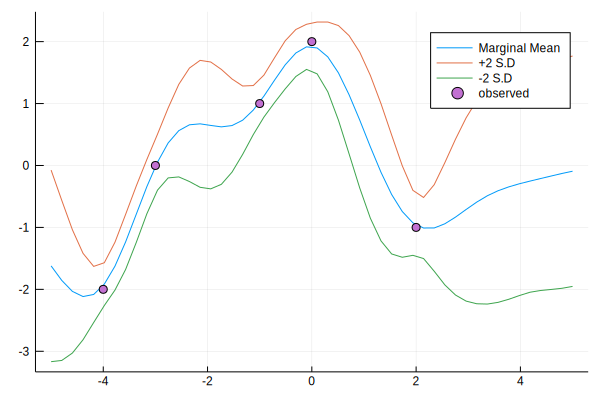

In [104]:
marginal_std = std(values, dims=2) ;

marginal_mean = mean(values, dims=2) ;

plot(x_star, marginal_mean, lab="Marginal Mean");
plot!(x_star, marginal_mean + (2*marginal_std), lab="+2 S.D");
plot!(x_star, marginal_mean - (2*marginal_std), lab="-2 S.D")
scatter!(f[1,:], f[2,:], lab="observed")